In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#!pip install pingouin
#!pip install scipy

In [43]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as stats
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)

# 1. 군집화

In [44]:
df=pd.read_csv('/content/drive/MyDrive/유진_나경_프로젝트 정리 폴더/빅데이터 활용 미래 사회문제 해결 아이디어 해커톤/Modeling/Clustering_data.csv',encoding='utf-8-sig')

In [45]:
df.columns

Index(['Unnamed: 0', '대교', '일자', '녹조', '주소', '상', '하', '상구', '상동', '하구', '하동',
       '총량지점명', '수소이온농도(ph)', '전기전도도(μS/㎝)', '용존산소(㎎/L)', 'BOD(㎎/L)_x',
       'COD(㎎/L)_x', '부유물질(㎎/L)', '총질소(T-N)(㎎/L)', '총인(T-P)(㎎/L)',
       '총유기탄소(TOC)(㎎/L)', '유량(㎥/s)', '방사선측정소명', '측정소코드', 'I-131(요오드)',
       '수질측정소명', '수온(℃)_y', 'DO(㎎/L)', 'BOD(㎎/L)_y', 'COD(㎎/L)_y', 'TN(㎎/L)',
       'TP(㎎/L)', 'TOC(㎎/L)', 'SS(㎎/L)', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '합계 일사량(MJ/m2)', '분기_m', '하구분기별인구수', '하동분기별인구수', '물재생센터명칭', '방류_BOD',
       '방류_TOC(2021년 1월 이전자료는 COD)', '방류_SS', '방류_T-N', '방류_TP', '방류_COCG',
       '년', '월', '일', '80mm이상비온날횟수', '방사선측정망까지의거리', '총량측정망까지의거리', '수질측정망까지의거리',
       '1차하수처리량', '2차하수처리량', '상동분기별인구수', '상구분기별인구수', '교통량', '총_유동인구_수_상구',
       '연령대_10_유동인구_수_상구', '연령대_20_유동인구_수_상구', '연령대_30_유동인구_수_상구',
       '연령대_40_유동인구_수_상구', '연령대_50_유동인구_수_상구', '연령대_60_이상_유동인구_수_상구',
       '총_유동인구_수_하구', '연령대_10_유동인구_수_하구', '연령대_20_유동인구_수_하구',
       '연령대_30_유동인구_수_하구', '연령대_40_유동인구_수_하구', 

In [46]:
#최종적으로 무의미해 뺐던 변수들
df.drop(columns=['Unnamed: 0','연령대_10_유동인구_수_상구', '연령대_20_유동인구_수_상구', '연령대_30_유동인구_수_상구',
       '연령대_40_유동인구_수_상구', '연령대_50_유동인구_수_상구', '연령대_60_이상_유동인구_수_상구','연령대_10_유동인구_수_하구', '연령대_20_유동인구_수_하구',
       '연령대_30_유동인구_수_하구', '연령대_40_유동인구_수_하구', '연령대_50_유동인구_수_하구',
       '연령대_60_이상_유동인구_수_하구'],inplace=True)

시각화 위한 PCA 우선 진행

In [47]:
#PCA를 위해 수치형만 골라내기 - 대교는 군집화에서 추가
df_num=df.copy()
df_num.drop(columns=['대교', '일자', '주소', '상', '하', '상구', '상동', '하구', '하동', '총량지점명', '방사선측정소명',
       '측정소코드', '수질측정소명', '분기_m', '물재생센터명칭'],inplace=True
            )

In [48]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
df_ss=std.fit_transform(df_num)

#이상치에 강한 scaler_ robust
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(df_num)
df_ro = scaler.transform(df_num)

#minmax - 분포 유지
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_num)  #train꺼로 transform한걸로 fit 중요!!!!
df_mm = scaler.transform(df_num)


In [49]:
from sklearn.decomposition import PCA

#1.
pca1=PCA(n_components=3)
X_low=pca1.fit_transform(df_num)
X2=pca1.inverse_transform(X_low)

#n차원으로 축소된 결과를 데이터프레임으로 나타내기
df_pca = pd.DataFrame(X_low, columns = ['component 0', 'component 1','component 2'])

In [50]:
#PCA 주성분 설명력 출력

print(pca1.explained_variance_ratio_)


[6.89883791e-01 3.10042769e-01 6.16407261e-05]


In [51]:
df_pca.head(5)

,component 0,component 1,component 2
0,3.515216e+07,-4.690255e+06,134667.420592
1,3.515075e+07,-4.695933e+06,-356623.413561
2,3.515227e+07,-4.690357e+06,147179.299193
3,3.515042e+07,-4.697664e+06,-490089.223513
4,3.515249e+07,-4.689540e+06,222025.610767


군집화 진행

In [52]:
#범주형 변수인 대교를 반영해주기 위해 kprototypes 클러스터링 진행함.
#!pip3 install kmodes

In [53]:
#범주형 변수의 위치를 확인해주기 위함임.
len(df_num.columns)

51

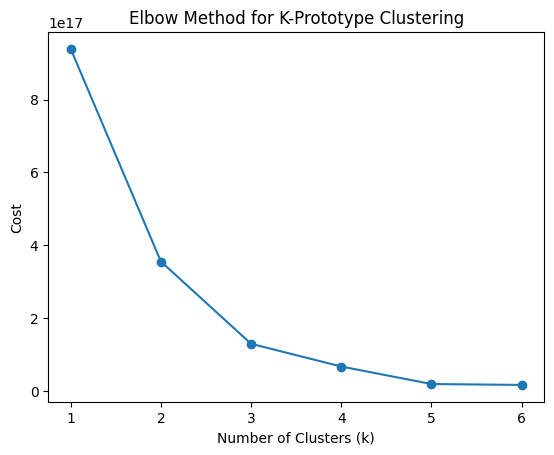

In [54]:
#엘보드 메소드
df_num['대교']=df['대교']

from kmodes.kprototypes import KPrototypes

# Perform k-prototype clustering for different values of k
costs = []
k_values = range(1, 7)  # You can adjust the range of k values
for k in k_values:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = kproto.fit_predict(df_num, categorical=[51])  # Specify the indices of categorical columns
    costs.append(kproto.cost_)

# Plot the elbow curve
plt.plot(k_values, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototype Clustering')
plt.show()

In [55]:
# Perform K-prototype clustering
kproto = KPrototypes(n_clusters=3, init='Cao', verbose=2,random_state=21)
clusters = kproto.fit_predict(df_num, categorical=[51])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 292, ncost: 2.0714071693322352e+17
Run: 1, iteration: 2/100, moves: 85, ncost: 1.5033244531877677e+17
Run: 1, iteration: 3/100, moves: 50, ncost: 1.2951079367404106e+17
Run: 1, iteration: 4/100, moves: 0, ncost: 1.2951079367404106e+17
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 278, ncost: 1.926643853541776e+17
Run: 2, iteration: 2/100, moves: 140, ncost: 1.4524553399930288e+17
Run: 2, iteration: 3/100, moves: 62, ncost: 1.2951079367404106e+17
Run: 2, iteration: 4/100, moves: 0, ncost: 1.2951079367404106e+17
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 157, ncost: 2.933120993706003e+17
Run: 3, iteration: 2/100, moves: 9, ncost: 2.9299006491521274e+17
Run: 3, iterati

In [56]:
#결과를 확인하기 위해 df_num+대교 데이터프레임 df_num copy
df_num['clusters']=clusters

In [57]:
df_num.groupby(['clusters','대교']).size()

clusters  대교  
0         광진교     159
          마포대교     32
          성산대교    151
          성수대교     12
          잠실철교     33
          한강대교     12
          한남대교     12
1         광진교      65
          성산대교     65
          성수대교     65
          한강대교     20
          한남대교    204
2         성수대교    138
dtype: int64

In [58]:
#pca 결과 확인
df_num.groupby('clusters').agg(['size','mean'])[['녹조','교통량','한강옆녹지_상구','한강옆녹지_하구','시민의식_환경']]

<ipython-input-58-32f76e41d513>:2: FutureWarning: ['대교'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_num.groupby('clusters').agg(['size','mean'])[['녹조','교통량','한강옆녹지_상구','한강옆녹지_하구','시민의식_환경']]


녹조              교통량                한강옆녹지_상구             한강옆녹지_하구  \
         size        mean size           mean     size        mean     size   
clusters                                                                      
0         411  172.625304  411   81714.014599      411   14.306569      411   
1         419  332.038186  419  144466.515513      419   76.014320      419   
2         138  174.311594  138  119523.282609      138  490.000000      138   

                      시민의식_환경            
                 mean    size      mean  
clusters                                 
0         9640.772482     411  6.075401  
1         2663.516945     419  5.687995  
2            0.000000     138  6.103913

In [59]:
#pca결과 기반 군집화 시각화

df_num['pca_x'] = df_pca['component 0']  #x좌표
df_num['pca_y'] = df_pca['component 1']  #y좌표
df_num['pca_z'] = df_pca['component 2']  #z좌표
df_num.head(5)

,녹조,수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L)_x,COD(㎎/L)_x,부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),I-131(요오드),수온(℃)_y,DO(㎎/L),BOD(㎎/L)_y,COD(㎎/L)_y,TN(㎎/L),TP(㎎/L),TOC(㎎/L),SS(㎎/L),평균기온(°C),일강수량(mm),평균 상대습도(%),합계 일사량(MJ/m2),하구분기별인구수,하동분기별인구수,방류_BOD,방류_TOC(2021년 1월 이전자료는 COD),방류_SS,방류_T-N,방류_TP,방류_COCG,년,월,일,80mm이상비온날횟수,방사선측정망까지의거리,총량측정망까지의거리,수질측정망까지의거리,1차하수처리량,2차하수처리량,상동분기별인구수,상구분기별인구수,교통량,총_유동인구_수_상구,총_유동인구_수_하구,한강옆녹지_상구,한강옆녹지_하구,녹지_상구,녹지_하구,시민의식_환경,대교,clusters,pca_x,pca_y,pca_z
0,0.0,8.5,169.0,10.5,1.9,4.1,5.0,1.562,0.018,2.3,110.277,0.731,24.4,7.3,5.5,7.5,8.221,0.067,4.4,4.6,24.2,0.0,33.3,26.62,568425.0,28355.0,16.3,18.2,9.5,40.626,0.326,2070.0,2017,6,5,0,4.327631,6.920544,4.211395,0.0,1156597.0,17225.0,311831.0,138251.0,64796817.0,73621361.0,490.0,0.00,1884.68,10232.27,4.89,성수대교,1,3.515216e+07,-4.690255e+06,134667.420592
1,0.0,8.5,169.0,10.5,1.9,4.1,5.0,1.562,0.018,2.3,110.277,0.731,23.8,7.4,1.9,5.1,1.331,0.031,2.3,10.2,24.2,0.0,33.3,26.62,453060.0,36240.0,11.8,17.3,4.4,24.041,0.271,2300.0,2017,6,5,0,5.364305,0.030274,2.169217,0.0,676617.0,36515.0,371728.0,17123.0,64796817.0,73621361.0,0.0,0.00,2597.12,5250.89,4.95,광진교,1,3.515075e+07,-4.695933e+06,-356623.413561
2,0.0,8.5,169.0,10.5,1.9,4.1,5.0,1.562,0.018,2.3,110.277,0.633,22.9,7.3,1.0,5.0,3.775,0.048,2.4,3.4,24.2,0.0,33.3,26.62,447936.0,35135.0,16.3,18.2,9.5,40.626,0.326,2070.0,2017,6,5,0,3.826156,9.021813,0.029925,0.0,1156597.0,23544.0,243406.0,164786.0,64796817.0,73621361.0,0.0,0.00,3552.88,11218.50,4.89,한남대교,1,3.515227e+07,-4.690357e+06,147179.299193
3,350.0,7.2,369.0,5.7,2.8,5.7,6.3,5.511,0.150,3.3,107.658,0.143,23.1,9.9,1.9,6.2,3.575,0.065,2.7,8.8,24.2,0.0,33.3,26.62,402967.0,22799.0,7.5,14.3,4.3,30.252,0.160,370.0,2017,6,5,0,7.411080,7.405319,0.505003,481.0,525016.0,20384.0,388574.0,175454.0,64796817.0,73621361.0,0.0,17169.44,8630.69,12598.06,4.88,성산대교,1,3.515042e+07,-4.697664e+06,-490089.223513
4,0.0,8.5,169.0,10.5,1.9,4.1,5.0,1.562,0.018,2.3,110.277,0.633,22.9,7.3,1.0,5.0,3.775,0.048,2.4,3.4,22.1,0.0,45.5,24.22,447936.0,35135.0,16.1,17.9,10.0,40.879,0.276,2200.0,2017,6,12,0,3.826156,9.021813,0.029925,60.0,1228797.0,23544.0,243406.0,205696.0,64796817.0,73621361.0,0.0,0.00,3552.88,11218.50,4.89,한남대교,1,3.515249e+07,-4.689540e+06,222025.610767


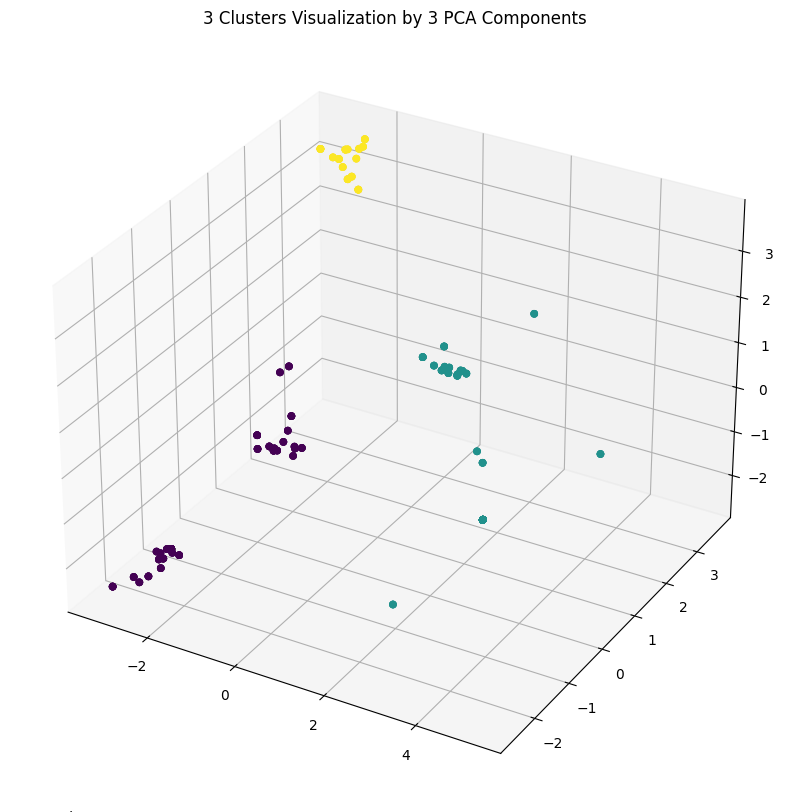

In [60]:
#pca가 3개가 나왔기에 pca3개로 진행 경우는(0이상 변수, k=2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = df_num['pca_x']
y = df_num['pca_y']
z = df_num['pca_y']
ax.scatter(x, y, z, c =df_num['clusters'], s= 20, alpha=0.5, label =df_num['clusters'])#cmap='rainbow')

#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.zlabel('PCA3')
plt.title('3 Clusters Visualization by 3 PCA Components')
plt.show()

In [61]:
#df_num.to_csv('all_all.csv',index=False)

# 2.분산분석 (변수의 개수 44개 -> 22개)

In [62]:
df=df_num.drop(columns=['pca_x', 'pca_y', 'pca_z'])
#df = pd.read_csv('/content/all_3.csv')
그룹0 = ['광진교','마포대교','성산대교','잠실철교']
그룹1 = ['한강대교','한남대교']
그룹2 = ['성수대교']

df0 = df.loc[df['clusters']==0].loc[df['대교'].isin(그룹0)]
df1 = df.loc[df['clusters']==1].loc[df['대교'].isin(그룹1)]
df2 = df.loc[df['clusters']==2].loc[df['대교'].isin(그룹2)]
cols = list(df.select_dtypes(include='number').columns)

## 정규성 검정 & 왜도 검사
for col in cols:
    print(col)
    print( ##Shaprio 검정
    stats.shapiro(df[col] )
    ## 왜도 측정
          , 'skewness test: {}'.format( abs(stats.skew(df[col], bias = False) ) )
          , sep = '\n')
    print()

녹조
ShapiroResult(statistic=0.12845027446746826, pvalue=0.0)
skewness test: 17.80469336004059

수소이온농도(ph)
ShapiroResult(statistic=0.9866108298301697, pvalue=9.795632394116183e-08)
skewness test: 0.27996974033874583

전기전도도(μS/㎝)
ShapiroResult(statistic=0.9776734113693237, pvalue=4.9732811618907746e-11)
skewness test: 0.6275481660594977

용존산소(㎎/L)
ShapiroResult(statistic=0.9926133155822754, pvalue=9.489156946074218e-05)
skewness test: 0.25391767494432016

BOD(㎎/L)_x
ShapiroResult(statistic=0.8750813007354736, pvalue=3.8342534224088725e-27)
skewness test: 1.8087680214365545

COD(㎎/L)_x
ShapiroResult(statistic=0.8683615326881409, pvalue=9.359923233224747e-28)
skewness test: 2.2692933236973354

부유물질(㎎/L)
ShapiroResult(statistic=0.5008147954940796, pvalue=1.401298464324817e-45)
skewness test: 5.5496137678150275

총질소(T-N)(㎎/L)
ShapiroResult(statistic=0.8836185932159424, pvalue=2.509583938480161e-26)
skewness test: 1.4399216381398552

총인(T-P)(㎎/L)
ShapiroResult(statistic=0.7550792098045349, pva

### 등분산성 검정

Levene's test

귀무가설: 모든 집단의 분산이 같다
.
if p-value < .05: 귀무가설 기각 성공. 모든 집단의 분산이 같지 않다. ➡️ pg.welch_anova

대립 가설 : 모든 집단의 분산이 같지 않다.


()

사용
if p-value > .05: 귀무가설 기각 실패. 모든 집단의 분산이 같다. ➡️ pg.anova 사용

In [63]:
welch_anova = []
anova = []
for col in cols:
    if stats.levene(df0[col],df1[col],df2[col])[1] < 0.05:
        print(col + '모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석')
        welch_anova.append(col)
        print()
    else:
        print(col +'모든 집단의 분산이 같으므로 pg.anova 분석')
        anova.append(col)
        print()

녹조모든 집단의 분산이 같으므로 pg.anova 분석

수소이온농도(ph)모든 집단의 분산이 같으므로 pg.anova 분석

전기전도도(μS/㎝)모든 집단의 분산이 같으므로 pg.anova 분석

용존산소(㎎/L)모든 집단의 분산이 같으므로 pg.anova 분석

BOD(㎎/L)_x모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

COD(㎎/L)_x모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

부유물질(㎎/L)모든 집단의 분산이 같으므로 pg.anova 분석

총질소(T-N)(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

총인(T-P)(㎎/L)모든 집단의 분산이 같으므로 pg.anova 분석

총유기탄소(TOC)(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

유량(㎥/s)모든 집단의 분산이 같으므로 pg.anova 분석

I-131(요오드)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

수온(℃)_y모든 집단의 분산이 같으므로 pg.anova 분석

DO(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

BOD(㎎/L)_y모든 집단의 분산이 같으므로 pg.anova 분석

COD(㎎/L)_y모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

TN(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

TP(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

TOC(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

SS(㎎/L)모든 집단의 분산이 같지 않으므로 pg.welch_anova 분석

평균기온(°C)모든 집단의 분산이 같으므로 pg.anova 분석

일강수량(mm)모든 집단의 분산이 같으므로 pg.anova 분석

평균 상대습도(%)모든 집단의 분산이 같으므로 pg.anova 분석

합계 일사량(MJ/m2)모든 집단의 분산이 같으므

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3189: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [64]:
anova

['녹조',
 '수소이온농도(ph)',
 '전기전도도(μS/㎝)',
 '용존산소(㎎/L)',
 '부유물질(㎎/L)',
 '총인(T-P)(㎎/L)',
 '유량(㎥/s)',
 '수온(℃)_y',
 'BOD(㎎/L)_y',
 '평균기온(°C)',
 '일강수량(mm)',
 '평균 상대습도(%)',
 '합계 일사량(MJ/m2)',
 '방류_TOC(2021년 1월 이전자료는 COD)',
 '방류_T-N',
 '월',
 '일',
 '80mm이상비온날횟수',
 '한강옆녹지_상구',
 'clusters']

### 모든 변수에 대해 등분산성 가정 만족 못하므로 welch_anova 해야함


H
0
 : 모든 모집단의 평균은 동일하다.

H
1
 : 모든 모집단의 평균이 동일한 것은 아니다.

In [65]:
import pingouin as pg
check_col = []
non_check_col = []

for col in welch_anova:
    if pg.welch_anova(dv = col, between = 'clusters', data = df)['p-unc'][0] < 0.05:
        print(col + '의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요')
        check_col.append(col)
    else:
        print(col + '모든 모집단의 평균은 동일하다.')
        non_check_col.append(col)

BOD(㎎/L)_x의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
COD(㎎/L)_x의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
총질소(T-N)(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
총유기탄소(TOC)(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
I-131(요오드)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
DO(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
COD(㎎/L)_y의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
TN(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
TP(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
TOC(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
SS(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
하구분기별인구수의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
하동분기별인구수의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방류_BOD의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방류_SS의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방류_TP의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방류_COCG의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
년의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방사선측정망까지의거리모든 모집단의 평균은 동일하다.
총량측정망까지의거리모든 모집단의 평균은 동일하다.
수질측정망까지의거리모든 모집단의 평균은 동일하다.
1차하수처리량모든 모집단의 평균은 동일하다.
2차하수처리량의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
상동분기별인구수의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
상구분기별인구수의 모든 모집단의 평균이 동일한 것은 아니

/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1346: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean(numeric_only=True)).sum() / weights.sum()
/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1346: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean(numeric_only=True)).sum() / weights.sum()
/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1346: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean(numeric_only=True)).sum() / weights.sum()
/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1346: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean(numeric_only=True)).sum() / weights.sum()
/usr/local/lib/python3.10/dist-packages/pingouin/parametric.py:1346: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.me

### 모든 변수에 대해 등분산성 가정 만족함로 anova 해야함


H
0
 : 모든 모집단의 평균은 동일하다.

H
1
 : 모든 모집단의 평균이 동일한 것은 아니다.

In [66]:
for col in anova:
    if pg.anova(dv =col, between = 'clusters', data = df)['p-unc'][0] < 0.05:
        print(col + '의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요')
        check_col.append(col)
    else:
        print(col + '모든 모집단의 평균은 동일하다.')
        non_check_col.append(col)

녹조모든 모집단의 평균은 동일하다.
수소이온농도(ph)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
전기전도도(μS/㎝)모든 모집단의 평균은 동일하다.
용존산소(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
부유물질(㎎/L)모든 모집단의 평균은 동일하다.
총인(T-P)(㎎/L)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
유량(㎥/s)모든 모집단의 평균은 동일하다.
수온(℃)_y의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
BOD(㎎/L)_y의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
평균기온(°C)모든 모집단의 평균은 동일하다.
일강수량(mm)모든 모집단의 평균은 동일하다.
평균 상대습도(%)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
합계 일사량(MJ/m2)모든 모집단의 평균은 동일하다.
방류_TOC(2021년 1월 이전자료는 COD)의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
방류_T-N의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
월의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
일모든 모집단의 평균은 동일하다.
80mm이상비온날횟수의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요
한강옆녹지_상구의 모든 모집단의 평균이 동일한 것은 아니다.. 사후검정 필요


ValueError: DV must be numeric.

### 사후분석

In [ ]:
reasoncol = []
for col in check_col:
    new_df = pg.pairwise_gameshowell(dv = col, between = 'clusters', data = df)
    difflist = list(new_df['pval'].values)
    indexlist = []
    for i , diff in enumerate(difflist):
        if diff <0.05:
            indexlist.append(i)
    if len(indexlist) >= 2:
        reasoncol.append(col)

### 다중공선성 확인

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(inputs): ## vif 계산 함수
  vif = pd.DataFrame()
  vif["variables"] = inputs.columns
  vif["VIF"] = ["{:.2f}".format(variance_inflation_factor(inputs.values, i)) for i in range(inputs.shape[1])]
  return(vif )

calc_vif(df[reasoncol])

In [ ]:
final_reasoncol = ['BOD(㎎/L)_x', 'COD(㎎/L)_x', '총질소(T-N)(㎎/L)', 'I-131(요오드)', 'DO(㎎/L)', 'COD(㎎/L)_y', 'TN(㎎/L)', 'TOC(㎎/L)', 'SS(㎎/L)',
                   '하동분기별인구수', '상동분기별인구수','방류_BOD', '방류_SS', '방류_TP', '방류_COCG', '2차하수처리량',  '교통량',
                   '총_유동인구_수_상구','총_유동인구_수_하구',  '한강옆녹지_하구', '시민의식_환경','녹조']